In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
import pickle
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_csv("data/car data.csv")

In [3]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [5]:
df.select_dtypes('object').describe()

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,8128,8128,8128,8128,8128,7907,7907,7913,7906
unique,2058,4,3,2,5,393,121,322,441
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm
freq,129,4402,6766,7078,5289,225,1017,377,530


In [6]:
print((df['name'].str.split(expand=True)[0].unique()))

['Maruti' 'Skoda' 'Honda' 'Hyundai' 'Toyota' 'Ford' 'Renault' 'Mahindra'
 'Tata' 'Chevrolet' 'Fiat' 'Datsun' 'Jeep' 'Mercedes-Benz' 'Mitsubishi'
 'Audi' 'Volkswagen' 'BMW' 'Nissan' 'Lexus' 'Jaguar' 'Land' 'MG' 'Volvo'
 'Daewoo' 'Kia' 'Force' 'Ambassador' 'Ashok' 'Isuzu' 'Opel' 'Peugeot']


In [7]:
df['name'].str.split(expand=True).head(20)

,0,1,2,3,4,5,6,7,8,9
0,Maruti,Swift,Dzire,VDI,None,None,None,None,None,None
1,Skoda,Rapid,1.5,TDI,Ambition,None,None,None,None,None
2,Honda,City,2017-2020,EXi,None,None,None,None,None,None
3,Hyundai,i20,Sportz,Diesel,None,None,None,None,None,None
4,Maruti,Swift,VXI,BSIII,None,None,None,None,None,None
5,Hyundai,Xcent,1.2,VTVT,E,Plus,None,None,None,None
6,Maruti,Wagon,R,LXI,DUO,BSIII,None,None,None,None
7,Maruti,800,DX,BSII,None,None,None,None,None,None
8,Toyota,Etios,VXD,None,None,None,None,None,None,None
9,Ford,Figo,Diesel,Celebration,Edition,None,None,None,None,None


In [8]:
# with 2058 unique values the name column might cause overfitting if used directly.
# possible options are to ignore and observe the performance of the model without it 
# or to extract the brand e.g honda, hyundai etc for the name and observe performance. 
# the client for this model wanted the car brand and model to be used in prediction so second option is used

# potentially extrracting brand and model, slight further cleaning needed tho
print((df['name'].str.split(expand=True)[0]+df['name'].str.split(expand=True)[1]).nunique())
print((df['name'].str.split(expand=True)[0]+df['name'].str.split(expand=True)[1]).value_counts())

210
MarutiSwift              782
MarutiAlto               420
Hyundaii20               341
MarutiWagon              282
ToyotaInnova             235
MahindraBolero           202
HyundaiVerna             197
HyundaiGrand             194
HondaCity                179
MahindraScorpio          166
FordFigo                 164
TataIndica               152
MarutiErtiga             147
MahindraXUV500           141
Hyundaii10               136
TataIndigo               136
HyundaiSantro            135
HyundaiEON               134
MarutiBaleno             113
ToyotaEtios              111
RenaultKWID              108
HondaAmaze               102
Maruti800                 93
HyundaiCreta              88
MarutiVitara              84
HyundaiXcent              82
FordEcoSport              82
MarutiRitz                81
VolkswagenPolo            77
RenaultDuster             75
HondaJazz                 74
TataTiago                 68
MarutiCiaz                68
SkodaRapid                66
TataSafari

In [9]:
complete_brands = [
    'Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault', 'Mahindra',
    'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep', 'Mercedes-Benz', 'Mitsubishi',
    'Audi', 'Volkswagen', 'BMW', 'Nissan', 'Lexus', 'Jaguar', 'MG', 'Volvo', 'Daewoo',
    'Kia', 'Force', 'Ambassador', 'Isuzu', 'Opel', 'Peugeot', 'Land Rover', 'Ashok Leyland'
]

# Define a function to extract brand and model
def extract_brand_model(name):
    parts = name.split()  # Split the name by spaces
    brand = ''
    model = ''

    # Identify and extract the brand
    if len(parts) > 1:
        # Check if the first part is a complete brand
        if parts[0] in complete_brands:
            brand = parts[0]
            model = parts[1]
        # Check if the first two parts combined form a complete brand (e.g., 'Land Rover')
        elif ' '.join(parts[:2]) in complete_brands:
            brand = ' '.join(parts[:2])
            model = parts[2] if len(parts) > 2 else ''
        else:
            # If no complete brand found, assume the first part is the brand and combine further for model
            brand = parts[0]
            model = ' '.join(parts[1:3])  # Attempt to combine for full model
    else:
        brand = parts[0]  # If only one part, assume it's the brand
    
    return brand, model

# Apply the function to extract brand and model and create new columns
df[['brand', 'model']] = df['name'].apply(lambda x: pd.Series(extract_brand_model(x)))

# Display the dataframe to check the extraction




In [10]:
# brand appears to be complete
df['brand'].unique()

array(['Maruti', 'Skoda', 'Honda', 'Hyundai', 'Toyota', 'Ford', 'Renault',
       'Mahindra', 'Tata', 'Chevrolet', 'Fiat', 'Datsun', 'Jeep',
       'Mercedes-Benz', 'Mitsubishi', 'Audi', 'Volkswagen', 'BMW',
       'Nissan', 'Lexus', 'Jaguar', 'Land Rover', 'MG', 'Volvo', 'Daewoo',
       'Kia', 'Force', 'Ambassador', 'Ashok Leyland', 'Isuzu', 'Opel',
       'Peugeot'], dtype=object)

In [11]:
# lets examine the models
(df['brand'] + ' ' + df['model'] ).nunique()

212

In [12]:
# luckily these can be physically examined

In [13]:

(df['brand'] + ' ' + df['model'] ).value_counts()

Maruti Swift              782
Maruti Alto               420
Hyundai i20               341
Maruti Wagon              282
Toyota Innova             235
Mahindra Bolero           202
Hyundai Verna             197
Hyundai Grand             194
Honda City                179
Mahindra Scorpio          166
Ford Figo                 164
Tata Indica               152
Maruti Ertiga             147
Mahindra XUV500           141
Tata Indigo               136
Hyundai i10               136
Hyundai Santro            135
Hyundai EON               134
Maruti Baleno             113
Toyota Etios              111
Renault KWID              108
Honda Amaze               102
Maruti 800                 93
Hyundai Creta              88
Maruti Vitara              84
Ford EcoSport              82
Hyundai Xcent              82
Maruti Ritz                81
Volkswagen Polo            77
Renault Duster             75
Honda Jazz                 74
Maruti Ciaz                68
Tata Tiago                 68
Skoda Rapi

In [14]:
# examining Isuzu mu
df[(df['brand'] + ' ' + df['model']) =='Isuzu MU' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
7336,Isuzu MU 7 AT Premium,2016,1160000,121000,Diesel,Dealer,Automatic,First Owner,12.08 kmpl,2999 CC,161 bhp,333Nm@ 1600-3200rpm,7.0,Isuzu,MU


In [15]:
# this would be replaced with Isuzu MU-7
df.loc[(df['brand'] == 'Isuzu') & (df['model'] == 'MU'), 'model'] = 'MU-7'

In [16]:
# examining toyota land
df[(df['brand'] + ' ' + df['model']) =='Toyota Land' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
6217,Toyota Land Cruiser Prado VX L,2014,3500000,60000,Diesel,Individual,Automatic,First Owner,11.0 kmpl,2982 CC,170.30 bhp,410Nm@ 1600-2800rpm,7.0,Toyota,Land


In [17]:
df.loc[(df['brand'] == 'Toyota') & (df['model'] == 'Land'), 'model'] = 'Land Cruiser'

In [18]:
df[(df['brand'] + ' ' + df['model']) =='BMW 7' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
2722,BMW 7 Series 730Ld,2007,750000,60000,Diesel,Individual,Automatic,Second Owner,14.49 kmpl,2993 CC,258 bhp,560Nm@ 1500rpm,5.0,BMW,7
5710,BMW 7 Series 730Ld,2010,2000000,90000,Diesel,Individual,Automatic,Second Owner,14.49 kmpl,2993 CC,258 bhp,560Nm@ 1500rpm,5.0,BMW,7


In [19]:
df.loc[(df['brand'] == 'BMW') & (df['model'] == '7'), 'model'] = '7 Series'

In [20]:
df[(df['brand'] + ' ' + df['model']) =='Mercedes-Benz B' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
49,Mercedes-Benz B Class B180,2014,1450000,27800,Diesel,Dealer,Automatic,Second Owner,14.8 kmpl,2143 CC,120.7 bhp,200Nm@ 1250-4000rpm,5.0,Mercedes-Benz,B
2932,Mercedes-Benz B Class B180 Sports,2014,1250000,42000,Petrol,Individual,Automatic,First Owner,11.9 kmpl,1595 CC,120.7 bhp,200Nm@ 1250-4000rpm,5.0,Mercedes-Benz,B
7447,Mercedes-Benz B Class B200 CDI Sport,2016,1859000,40000,Diesel,Individual,Automatic,Second Owner,19.7 kmpl,2143 CC,134.10 bhp,300Nm@ 1600-3000rpm,5.0,Mercedes-Benz,B
7797,Mercedes-Benz B Class B200 CDI Sport,2015,2051000,35000,Diesel,Dealer,Automatic,Second Owner,19.7 kmpl,2143 CC,134.10 bhp,300Nm@ 1600-3000rpm,5.0,Mercedes-Benz,B


In [21]:
df.loc[(df['brand'] == 'Mercedes-Benz') & (df['model'] == 'B'), 'model'] = 'B Class'

In [22]:
df[(df['brand'] + ' ' + df['model']) =='Mahindra Ssangyong' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
233,Mahindra Ssangyong Rexton RX5,2013,900000,70000,Diesel,Individual,Manual,First Owner,12.83 kmpl,2696 CC,162 bhp,340Nm@ 1800-3250rpm,7.0,Mahindra,Ssangyong
1364,Mahindra Ssangyong Rexton RX7,2013,800000,117000,Diesel,Dealer,Automatic,First Owner,11.18 kmpl,2696 CC,184 bhp,402Nm@ 1600-3000rpm,7.0,Mahindra,Ssangyong
2462,Mahindra Ssangyong Rexton RX7,2013,1000000,40000,Diesel,Individual,Automatic,First Owner,11.18 kmpl,2696 CC,184 bhp,402Nm@ 1600-3000rpm,7.0,Mahindra,Ssangyong
4046,Mahindra Ssangyong Rexton RX7,2013,850000,200000,Diesel,Individual,Automatic,First Owner,11.18 kmpl,2696 CC,184 bhp,402Nm@ 1600-3000rpm,7.0,Mahindra,Ssangyong
4741,Mahindra Ssangyong Rexton RX7,2013,800000,117000,Diesel,Dealer,Automatic,First Owner,11.18 kmpl,2696 CC,184 bhp,402Nm@ 1600-3000rpm,7.0,Mahindra,Ssangyong


In [23]:
df.loc[(df['brand'] == 'Mahindra') & (df['model'] == 'Ssangyong'), 'brand'] = 'Mahindra Ssangyong'

In [24]:
df.loc[(df['brand'] == 'Mahindra Ssangyong') & (df['model'] == 'Ssangyong'), 'model'] = 'Rexton'

In [25]:
df[(df['brand'] + ' ' + df['model']) =='Hyundai Santa' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
984,Hyundai Santa Fe 4WD AT,2014,900000,80000,Diesel,Individual,Automatic,Second Owner,13.01 kmpl,2199 CC,194.3 bhp,436.39Nm@ 1800-2500rpm,7.0,Hyundai,Santa
1296,Hyundai Santa Fe 2WD AT,2014,1050000,146000,Diesel,Individual,Automatic,Second Owner,13.01 kmpl,2199 CC,194.3 bhp,436.39Nm@ 1800-2500rpm,7.0,Hyundai,Santa
2400,Hyundai Santa Fe 4X4,2011,825000,125000,Diesel,Individual,Manual,Second Owner,14.66 kmpl,2199 CC,194.3 bhp,420.7Nm@ 1800-2500rpm,7.0,Hyundai,Santa
3604,Hyundai Santa Fe 2WD MT,2014,1100000,80000,Diesel,Individual,Manual,First Owner,14.74 kmpl,2199 CC,194.3 bhp,420.7Nm@ 1800-2500rpm,7.0,Hyundai,Santa
8023,Hyundai Santa Fe 4x4 AT,2011,1200000,62000,Diesel,Individual,Automatic,Second Owner,11.72 kmpl,2199 CC,194.3 bhp,436.4Nm@ 1800-2500rpm,7.0,Hyundai,Santa


In [26]:
df.loc[(df['brand'] == 'Hyundai') & (df['model'] == 'Santa'), 'model'] = 'Santa Fe'

In [27]:
df[(df['brand'] + ' ' + df['model']) =='Land Rover Range' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
6724,Land Rover Range Rover Evoque 2.2L Pure,2013,2000000,77500,Diesel,Individual,Automatic,Third Owner,12.7 kmpl,2179 CC,187.7 bhp,420Nm@ 2000rpm,5.0,Land Rover,Range


In [28]:
df.loc[(df['brand'] == 'Land Rover') & (df['model'] == 'Range'), 'model'] = 'Range Rover'

In [29]:
df[(df['brand'] + ' ' + df['model']) =='Toyota Platinum' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
3137,Toyota Platinum Etios 1.4 GXD,2018,730000,90000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0,Toyota,Platinum
3825,Toyota Platinum Etios 1.4 GD,2017,632000,150000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0,Toyota,Platinum
4565,Toyota Platinum Etios 1.4 GXD,2018,670000,150000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0,Toyota,Platinum
5935,Toyota Platinum Etios 1.4 GXD,2017,550000,40000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0,Toyota,Platinum
7428,Toyota Platinum Etios 1.4 GXD,2018,780000,116000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0,Toyota,Platinum
7588,Toyota Platinum Etios 1.4 GXD,2018,780000,116000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.05 bhp,170Nm@ 1800-2400rpm,5.0,Toyota,Platinum


In [30]:
df.loc[(df['brand'] == 'Toyota') & (df['model'] == 'Platinum'), 'model'] = 'Platinum Etios'

In [31]:
df[(df['brand'] + ' ' + df['model']) =='BMW 6' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
1071,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0,BMW,6
4101,BMW 6 Series GT 630d Luxury Line,2018,6000000,28156,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0,BMW,6
4753,BMW 6 Series GT 630d Luxury Line,2018,5500000,22000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0,BMW,6
4766,BMW 6 Series GT 630d Luxury Line,2018,6000000,27000,Diesel,Dealer,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0,BMW,6
6258,BMW 6 Series GT 630d Luxury Line,2018,5830000,30000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0,BMW,6
7596,BMW 6 Series GT 630d Luxury Line,2018,5830000,30000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0,BMW,6


In [32]:
df.loc[(df['brand'] == 'BMW') & (df['model'] == '6'), 'model'] = '6 Series'

In [33]:
df[(df['brand'] + ' ' + df['model']) =='Mahindra Renault' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
1536,Mahindra Renault Logan 1.4 GLX Petrol,2009,135000,120000,Petrol,Individual,Manual,First Owner,15.7 kmpl,1390 CC,75 bhp,"11@ 3,000(kgm@ rpm)",5.0,Mahindra,Renault
1659,Mahindra Renault Logan 1.5 Diesel DLSX,2009,200000,176000,Diesel,Individual,Manual,Second Owner,17.0 kmpl,1461 CC,66 bhp,"16@ 2,000(kgm@ rpm)",5.0,Mahindra,Renault
1663,Mahindra Renault Logan 1.5 DLX Diesel,2007,175000,99000,Diesel,Individual,Manual,Second Owner,19.2 kmpl,1461 CC,65 bhp,"16@ 2,000(kgm@ rpm)",5.0,Mahindra,Renault
2860,Mahindra Renault Logan 1.5 DLE Diesel,2009,125000,120000,Diesel,Individual,Manual,Third Owner,19.2 kmpl,1461 CC,65 bhp,"16@ 2,000(kgm@ rpm)",5.0,Mahindra,Renault
6311,Mahindra Renault Logan 1.5 DLE Diesel,2007,150000,120000,Diesel,Individual,Manual,Second Owner,19.2 kmpl,1461 CC,65 bhp,"16@ 2,000(kgm@ rpm)",5.0,Mahindra,Renault
7321,Mahindra Renault Logan 1.5 DLE Diesel,2007,180000,187000,Diesel,Individual,Manual,Second Owner,19.2 kmpl,1461 CC,65 bhp,"16@ 2,000(kgm@ rpm)",5.0,Mahindra,Renault


In [34]:
df.loc[(df['brand'] == 'Mahindra') & (df['model'] == 'Renault'), 'brand'] = 'Mahindra Renault'

In [35]:
df.loc[(df['brand'] == 'Mahindra Renault') & (df['model'] == 'Renault'), 'model'] = 'Logan'

In [36]:
df[(df['brand'] + ' ' + df['model']) =='Mahindra Jeep' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
1216,Mahindra Jeep Classic,1996,163000,5000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN,Mahindra,Jeep
1432,Mahindra Jeep CL 500 MDI,1994,120000,100000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN,Mahindra,Jeep
1815,Mahindra Jeep MM 540,1995,160000,90000,Diesel,Individual,Manual,Third Owner,NaN,NaN,NaN,NaN,NaN,Mahindra,Jeep
2867,Mahindra Jeep MM 550 XDB,2005,400000,30000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN,Mahindra,Jeep
3922,Mahindra Jeep MM 540,1998,210000,47990,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN,Mahindra,Jeep
5385,Mahindra Jeep CL 500 MDI,1997,160000,100000,Diesel,Individual,Manual,Fourth & Above Owner,NaN,NaN,NaN,NaN,NaN,Mahindra,Jeep


In [37]:
df[(df['brand'] + ' ' + df['model']) =='Honda BRV' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
1052,Honda BRV i-VTEC V CVT,2017,950000,15000,Petrol,Individual,Automatic,First Owner,15.4 kmpl,1497 CC,117.3 bhp,145Nm@ 4600rpm,7.0,Honda,BRV
1273,Honda BRV i-DTEC V MT,2016,850000,72113,Diesel,Individual,Manual,First Owner,21.9 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,7.0,Honda,BRV
2833,Honda BRV i-VTEC V CVT,2017,850000,30000,Petrol,Dealer,Automatic,First Owner,15.4 kmpl,1497 CC,117.3 bhp,145Nm@ 4600rpm,7.0,Honda,BRV
3282,Honda BRV i-DTEC V MT,2016,950000,60000,Diesel,Individual,Manual,First Owner,21.9 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,7.0,Honda,BRV
4814,Honda BRV i-DTEC V MT,2019,1100000,50000,Diesel,Individual,Manual,Second Owner,21.9 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,7.0,Honda,BRV
5515,Honda BRV i-DTEC V MT,2017,940000,57900,Diesel,Dealer,Manual,First Owner,21.9 kmpl,1498 CC,98.6 bhp,200Nm@ 1750rpm,7.0,Honda,BRV
7061,Honda BRV i-VTEC V MT,2016,725000,140000,Petrol,Individual,Manual,First Owner,15.4 kmpl,1497 CC,117.3 bhp,145Nm@ 4600rpm,7.0,Honda,BRV
7853,Honda BRV i-VTEC V CVT,2017,950000,15000,Petrol,Individual,Automatic,First Owner,15.4 kmpl,1497 CC,117.3 bhp,145Nm@ 4600rpm,7.0,Honda,BRV


In [38]:
df[(df['brand'] + ' ' + df['model']) =='Mercedes-Benz New' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
60,Mercedes-Benz New C-Class 220 CDI AT,2013,1425000,59000,Diesel,Dealer,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0,Mercedes-Benz,New
158,Mercedes-Benz New C-Class C 200 AVANTGARDE,2017,2700000,16000,Petrol,Dealer,Automatic,First Owner,14.74 kmpl,1991 CC,181.04 bhp,300Nm@ 1200-1400rpm,5.0,Mercedes-Benz,New
362,Mercedes-Benz New C-Class 220 CDI AT,2013,1550000,25000,Diesel,Individual,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0,Mercedes-Benz,New
1255,Mercedes-Benz New C-Class 220 CDI AT,2012,1400000,50000,Diesel,Individual,Automatic,First Owner,14.84 kmpl,2143 CC,170 bhp,400Nm@ 1400-2800rpm,5.0,Mercedes-Benz,New
1990,Mercedes-Benz New C-Class C 220 CDI Elegance MT,2018,2950000,46000,Diesel,Dealer,Manual,First Owner,15.8 kmpl,2148 CC,170 bhp,"42@ 2,000(kgm@ rpm)",5.0,Mercedes-Benz,New
3107,Mercedes-Benz New C-Class C 200 Kompressor Ele...,2007,400000,42000,Petrol,Dealer,Automatic,First Owner,11.74 kmpl,1796 CC,186 bhp,285Nm@ 2400-4000rpm,5.0,Mercedes-Benz,New
4299,Mercedes-Benz New C-Class C 200 Kompressor Ele...,2006,650000,40000,Petrol,Individual,Manual,First Owner,11.7 kmpl,1796 CC,178 bhp,"24.5@ 3,500-4,500(kgm@ rpm)",5.0,Mercedes-Benz,New
4789,Mercedes-Benz New C-Class C 200 AVANTGARDE,2017,2700000,16000,Petrol,Dealer,Automatic,First Owner,14.74 kmpl,1991 CC,181.04 bhp,300Nm@ 1200-1400rpm,5.0,Mercedes-Benz,New
5178,Mercedes-Benz New C-Class 200 K AT,2007,500000,120000,Petrol,Individual,Automatic,First Owner,11.7 kmpl,1796 CC,178 bhp,"24.5@ 3,500-4,500(kgm@ rpm)",5.0,Mercedes-Benz,New
5400,Mercedes-Benz New C-Class C 250 CDI Elegance,2011,1000000,90000,Diesel,Dealer,Automatic,First Owner,14.94 kmpl,2143 CC,204 bhp,500Nm@ 1600-1800rpm,5.0,Mercedes-Benz,New


In [39]:
df.loc[(df['brand'] == 'Mercedes-Benz') & (df['model'] == 'New'), 'model'] = 'C-Class'

In [40]:
df[(df['brand'] + ' ' + df['model']) =='BMW 5' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
137,BMW 5 Series 520d Sport Line,2018,3790000,29500,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0,BMW,5
149,BMW 5 Series 523i,2010,975000,72200,Petrol,Dealer,Automatic,Second Owner,10.8 kmpl,2497 CC,150 bhp,250 Nm at 2750 rpm,5.0,BMW,5
167,BMW 5 Series 520d Luxury Line,2016,2900000,12000,Diesel,Dealer,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0,BMW,5
2829,BMW 5 Series 520d Sport Line,2018,3900000,17100,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0,BMW,5
3241,BMW 5 Series 520d Sport Line,2018,3790000,29500,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0,BMW,5
4671,BMW 5 Series 520d Luxury Line,2019,5200000,10000,Diesel,Dealer,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0,BMW,5
4880,BMW 5 Series 525d,2010,1000000,60000,Diesel,Individual,Automatic,First Owner,16.73 kmpl,1995 CC,218 bhp,450Nm@ 1750-2500rpm,5.0,BMW,5
4901,BMW 5 Series 520d,2008,1100000,122000,Diesel,Individual,Automatic,Second Owner,18.48 kmpl,1995 CC,177 bhp,"35.7@ 1,750-3,000(kgm@ rpm)",5.0,BMW,5
5188,BMW 5 Series 520d Luxury Line,2016,3200000,40000,Diesel,Individual,Automatic,First Owner,18.12 kmpl,1995 CC,190 bhp,400Nm@ 1750-2500rpm,5.0,BMW,5
5259,BMW 5 Series 520d Sport Line,2018,4000000,10000,Diesel,Dealer,Automatic,First Owner,22.48 kmpl,1995 CC,187.74 bhp,400Nm@ 1750-2500rpm,5.0,BMW,5


In [41]:
df.loc[(df['brand'] == 'BMW') & (df['model'] == '5'), 'model'] = '5 Series'

In [42]:
df[(df['brand'] + ' ' + df['model']) =='Fiat Grande' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
669,Fiat Grande Punto Sport 90BHP,2013,400000,90000,Diesel,Individual,Manual,First Owner,20.3 kmpl,1248 CC,92 bhp,209Nm@ 2000rpm,5.0,Fiat,Grande
1295,Fiat Grande Punto 1.3 Emotion Pack 90HP (Diesel),2011,280000,200000,Diesel,Individual,Manual,First Owner,20.5 kmpl,1248 CC,91.7 bhp,209Nm@ 2000rpm,5.0,Fiat,Grande
2099,Fiat Grande Punto EVO 1.3 Dynamic,2015,300000,95000,Diesel,Individual,Manual,Third Owner,21.2 kmpl,1248 CC,75 bhp,197Nm@ 1750rpm,5.0,Fiat,Grande
2199,Fiat Grande Punto Active (Diesel),2013,280000,52000,Diesel,Individual,Manual,First Owner,20.3 kmpl,1248 CC,75 bhp,197Nm@ 1750rpm,5.0,Fiat,Grande
2532,Fiat Grande Punto EVO 1.3 Active,2014,320000,39395,Diesel,Individual,Manual,First Owner,21.2 kmpl,1248 CC,75 bhp,197Nm@ 1750rpm,5.0,Fiat,Grande
2621,Fiat Grande Punto 1.4 Emotion,2009,150000,55000,Petrol,Individual,Manual,First Owner,14.6 kmpl,1368 CC,88.7 bhp,115Nm@ 4500rpm,5.0,Fiat,Grande
2996,Fiat Grande Punto 1.3 Dynamic (Diesel),2013,250000,47000,Diesel,Individual,Manual,First Owner,20.3 kmpl,1248 CC,75 bhp,197Nm@ 1750rpm,5.0,Fiat,Grande
3986,Fiat Grande Punto EVO 1.3 Dynamic,2015,550000,67000,Diesel,Individual,Manual,First Owner,21.2 kmpl,1248 CC,75 bhp,197Nm@ 1750rpm,5.0,Fiat,Grande
3999,Fiat Grande Punto Active (Diesel),2012,170000,60000,Diesel,Individual,Manual,Second Owner,20.3 kmpl,1248 CC,75 bhp,197Nm@ 1750rpm,5.0,Fiat,Grande
4544,Fiat Grande Punto Sport 90BHP,2012,285000,70000,Diesel,Individual,Manual,Second Owner,20.3 kmpl,1248 CC,92 bhp,209Nm@ 2000rpm,5.0,Fiat,Grande


In [43]:
df.loc[(df['brand'] == 'Fiat') & (df['model'] == 'Grande'), 'model'] = 'Grande Punto'

In [44]:
df.loc[(df['brand'] == 'BMW') & (df['model'] == '3'), 'model'] = '3 Series'

In [45]:
df[(df['brand'] + ' ' + df['model']) =='Tata New' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
285,Tata New Safari DICOR 2.2 EX 4x2,2011,450000,80000,Diesel,Individual,Manual,Third Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
506,Tata New Safari DICOR 2.2 VX 4x2,2009,250000,146000,Diesel,Individual,Manual,Second Owner,13.93 kmpl,2179 CC,138 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
941,Tata New Safari 3L Dicor LX 4x2,2007,280000,160000,Diesel,Individual,Manual,Second Owner,13.93 kmpl,2956 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
1298,Tata New Safari DICOR 2.2 EX 4x2,2010,535000,96443,Diesel,Individual,Manual,Second Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
1354,Tata New Safari DICOR 2.2 EX 4x2,2008,150000,120000,Diesel,Individual,Manual,Fourth & Above Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
1467,Tata New Safari DICOR 2.2 EX 4x2,2008,300000,120000,Diesel,Individual,Manual,Second Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
1535,Tata New Safari DICOR 2.2 EX 4x2,2009,150000,150000,Diesel,Individual,Manual,Fourth & Above Owner,11.57 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
1605,Tata New Safari DICOR 2.2 EX 4x4,2011,300000,80000,Diesel,Individual,Manual,First Owner,13.93 kmpl,2179 CC,138 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
1757,Tata New Safari DICOR 2.2 VX 4x2 BS IV,2011,240000,120000,Diesel,Individual,Manual,First Owner,13.93 kmpl,2179 CC,138.1 bhp,320Nm@ 1700-2700rpm,7.0,Tata,New
1807,Tata New Safari 4X2,2007,300000,110000,Petrol,Individual,Manual,Second Owner,12.0 kmpl,2092 CC,127 bhp,"20@ 3,750(kgm@ rpm)",7.0,Tata,New


In [46]:
df.loc[(df['brand'] == 'Tata') & (df['model'] == 'New'), 'model'] = 'Safari'

In [47]:
df[(df['brand'] + ' ' + df['model']) =='Mahindra KUV' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
15,Mahindra KUV 100 mFALCON G80 K8 5str,2016,400000,40000,Petrol,Individual,Manual,First Owner,18.15 kmpl,1198 CC,82 bhp,115Nm@ 3500-3600rpm,5.0,Mahindra,KUV
188,Mahindra KUV 100 mFALCON G80 K8,2016,450000,15000,Petrol,Individual,Manual,Second Owner,18.15 kmpl,1198 CC,82 bhp,115Nm@ 3500-3600rpm,6.0,Mahindra,KUV
475,Mahindra KUV 100 mFALCON D75 K8,2016,280000,100000,Diesel,Individual,Manual,First Owner,25.32 kmpl,1198 CC,77 bhp,190Nm@ 1750-2250rpm,6.0,Mahindra,KUV
487,Mahindra KUV 100 D75 K6 Plus,2020,480000,44665,Diesel,Individual,Manual,First Owner,25.32 kmpl,1198 CC,77 bhp,190Nm@ 1750-2250rpm,6.0,Mahindra,KUV
676,Mahindra KUV 100 G80 K6 Plus,2018,535000,21000,Petrol,Individual,Manual,Second Owner,18.15 kmpl,1198 CC,82 bhp,115Nm@ 3500-3600rpm,6.0,Mahindra,KUV
683,Mahindra KUV 100 G80 K2,2018,340000,51492,Petrol,Individual,Manual,First Owner,18.15 kmpl,1198 CC,82 bhp,115Nm@ 3500-3600rpm,6.0,Mahindra,KUV
718,Mahindra KUV 100 mFALCON G80 K2,2016,300000,40000,Petrol,Individual,Manual,First Owner,18.15 kmpl,1198 CC,82 bhp,115Nm@ 3500-3600rpm,6.0,Mahindra,KUV
846,Mahindra KUV 100 mFALCON G80 K2,2016,327000,20000,Petrol,Individual,Manual,First Owner,18.15 kmpl,1198 CC,82 bhp,115Nm@ 3500-3600rpm,6.0,Mahindra,KUV
1042,Mahindra KUV 100 G80 K8,2018,650000,6000,Petrol,Individual,Manual,First Owner,18.15 kmpl,1198 CC,82 bhp,115Nm@ 3500-3600rpm,6.0,Mahindra,KUV
1746,Mahindra KUV 100 mFALCON D75 K6 Plus,2016,375000,80000,Diesel,Individual,Manual,First Owner,25.32 kmpl,1198 CC,77 bhp,190Nm@ 1750-2250rpm,6.0,Mahindra,KUV


In [48]:
df.loc[(df['brand'] == 'Mahindra') & (df['model'] == 'KUV'), 'model'] = 'KUV 100'

In [49]:
df[(df['brand'] + ' ' + df['model']) =='Mahindra TUV' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
610,Mahindra TUV 300 T8,2017,655000,126000,Diesel,Individual,Manual,First Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV
665,Mahindra TUV 300 T8,2015,634000,165000,Diesel,Individual,Manual,First Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV
673,Mahindra TUV 300 T8,2015,730000,100000,Diesel,Individual,Manual,First Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV
704,Mahindra TUV 300 T8,2015,590000,40000,Diesel,Individual,Manual,Second Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV
714,Mahindra TUV 300 T6 Plus,2019,875000,25000,Diesel,Individual,Manual,First Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV
918,Mahindra TUV 300 T6 Plus,2016,700000,120000,Diesel,Individual,Manual,First Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV
924,Mahindra TUV 300 Plus P4 BSIV,2018,600000,70000,Diesel,Individual,Manual,First Owner,18.49 kmpl,2179 CC,120 bhp,280Nm@ 1800-2800rpm,9.0,Mahindra,TUV
1169,Mahindra TUV 300 T8,2016,750000,71000,Diesel,Individual,Manual,First Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV
1373,Mahindra TUV 300 T4 Plus,2018,775000,59736,Diesel,Dealer,Manual,First Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV
1547,Mahindra TUV 300 T4,2017,509999,142000,Diesel,Individual,Manual,First Owner,18.49 kmpl,1493 CC,100 bhp,240Nm@ 1600-2800rpm,7.0,Mahindra,TUV


In [50]:
df.loc[(df['brand'] == 'Mahindra') & (df['model'] == 'TUV'), 'model'] = 'TUV 300'

In [51]:
df[(df['brand'] + ' ' + df['model']) =='Maruti Vitara' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
30,Maruti Vitara Brezza LDi Option,2017,670000,70000,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
34,Maruti Vitara Brezza LDi,2017,650000,16200,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
45,Maruti Vitara Brezza VDi,2018,819999,32600,Diesel,Dealer,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
71,Maruti Vitara Brezza VDi,2016,745000,70000,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
72,Maruti Vitara Brezza ZDi Plus AMT,2019,1025000,9850,Diesel,Individual,Automatic,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
116,Maruti Vitara Brezza ZDi Plus Dual Tone,2016,780000,60000,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
223,Maruti Vitara Brezza VDi Option,2017,775000,75000,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
549,Maruti Vitara Brezza ZDi Plus Dual Tone,2017,775000,32000,Diesel,Dealer,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
552,Maruti Vitara Brezza VDi,2018,750000,5000,Diesel,Individual,Manual,First Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara
761,Maruti Vitara Brezza ZDi Plus Dual Tone,2016,700000,110000,Diesel,Individual,Manual,Second Owner,24.3 kmpl,1248 CC,88.5 bhp,200Nm@ 1750rpm,5.0,Maruti,Vitara


In [52]:
df.loc[(df['brand'] == 'Maruti') & (df['model'] == 'Vitara'), 'model'] = 'Vitara Brezza'

In [53]:
df[(df['brand'] + ' ' + df['model']) =='Hyundai Grand' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
179,Hyundai Grand i10 Magna,2015,425000,70000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0,Hyundai,Grand
181,Hyundai Grand i10 Sportz,2014,400000,60000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0,Hyundai,Grand
282,Hyundai Grand i10 AT Asta,2015,465000,63063,Petrol,Dealer,Automatic,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0,Hyundai,Grand
290,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0,Hyundai,Grand
291,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0,Hyundai,Grand
305,Hyundai Grand i10 CRDi Sportz,2015,395000,80000,Diesel,Individual,Manual,Second Owner,24.0 kmpl,1120 CC,70 bhp,160Nm@ 1500-2750rpm,5.0,Hyundai,Grand
322,Hyundai Grand i10 1.2 CRDi Sportz,2018,520000,29000,Diesel,Individual,Manual,First Owner,24.0 kmpl,1186 CC,73.97 bhp,190.24nm@ 1750-2250rpm,5.0,Hyundai,Grand
349,Hyundai Grand i10 Asta,2015,434999,40000,Petrol,Dealer,Manual,First Owner,18.9 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0,Hyundai,Grand
383,Hyundai Grand i10 1.2 CRDi Sportz,2017,450000,56290,Diesel,Dealer,Manual,First Owner,24.0 kmpl,1186 CC,73.97 bhp,190.24nm@ 1750-2250rpm,5.0,Hyundai,Grand
422,Hyundai Grand i10 1.2 CRDi Sportz,2017,450000,56290,Diesel,Dealer,Manual,First Owner,24.0 kmpl,1186 CC,73.97 bhp,190.24nm@ 1750-2250rpm,5.0,Hyundai,Grand


In [54]:
df.loc[(df['brand'] == 'Hyundai') & (df['model'] == 'Grand'), 'model'] = 'Grand i10'

In [55]:
df[(df['brand'] + ' ' + df['model']) =='Maruti Wagon' ]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand,model
6,Maruti Wagon R LXI DUO BSIII,2007,96000,175000,LPG,Individual,Manual,First Owner,17.3 km/kg,1061 CC,57.5 bhp,"7.8@ 4,500(kgm@ rpm)",5.0,Maruti,Wagon
14,Maruti Wagon R LXI Minor,2009,180000,90000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,1061 CC,67 bhp,84Nm@ 3500rpm,5.0,Maruti,Wagon
28,Maruti Wagon R LXI Minor,2009,220000,120000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1061 CC,67 bhp,84Nm@ 3500rpm,5.0,Maruti,Wagon
69,Maruti Wagon R AMT VXI,2018,448000,30000,Petrol,Individual,Automatic,First Owner,20.51 kmpl,998 CC,67 bhp,90Nm@ 3500rpm,5.0,Maruti,Wagon
90,Maruti Wagon R LXI LPG BSIV,2010,225000,44000,LPG,Dealer,Manual,First Owner,26.2 km/kg,998 CC,58.2 bhp,77Nm@ 3500rpm,5.0,Maruti,Wagon
100,Maruti Wagon R VXI,2009,185000,77000,Petrol,Dealer,Manual,Second Owner,21.79 kmpl,998 CC,67.05 bhp,90Nm@ 3500rpm,5.0,Maruti,Wagon
118,Maruti Wagon R VXI BS IV,2017,440000,35000,Petrol,Individual,Manual,First Owner,20.51 kmpl,998 CC,67.04 bhp,90Nm@ 3500rpm,5.0,Maruti,Wagon
175,Maruti Wagon R AMT VXI,2015,390000,50000,Petrol,Individual,Automatic,Second Owner,20.51 kmpl,998 CC,67 bhp,90Nm@ 3500rpm,5.0,Maruti,Wagon
192,Maruti Wagon R VXI BS IV with ABS,2010,215000,120600,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1 bhp,90Nm@ 3500rpm,5.0,Maruti,Wagon
203,Maruti Wagon R LXI CNG,2016,360000,50000,CNG,Individual,Manual,First Owner,26.6 km/kg,998 CC,58.16 bhp,77Nm@ 3500rpm,5.0,Maruti,Wagon


In [56]:
df.loc[(df['brand'] == 'Maruti') & (df['model'] == 'Wagon'), 'model'] = 'Wagon R'

In [57]:
df.groupby('brand')['model'].apply(lambda x: list(set(x))).to_dict()

{'Ambassador': ['CLASSIC', 'Grand', 'Classic'],
 'Ashok Leyland': ['Stile'],
 'Audi': ['A3', 'Q7', 'Q5', 'A6', 'A4', 'Q3'],
 'BMW': ['7 Series',
  'X1',
  '6 Series',
  'X3',
  'X6',
  'X4',
  '3 Series',
  'X7',
  'X5',
  '5 Series'],
 'Chevrolet': ['Enjoy',
  'Optra',
  'Aveo',
  'Sail',
  'Tavera',
  'Spark',
  'Captiva',
  'Cruze',
  'Trailblazer',
  'Beat'],
 'Daewoo': ['Matiz'],
 'Datsun': ['GO', 'RediGO'],
 'Fiat': ['Linea', 'Grande Punto', 'Punto', 'Avventura', 'Palio'],
 'Force': ['Gurkha', 'One'],
 'Ford': ['Fiesta',
  'EcoSport',
  'Freestyle',
  'Figo',
  'Ikon',
  'Endeavour',
  'Ecosport',
  'Fusion',
  'Classic',
  'Aspire'],
 'Honda': ['Jazz',
  'CR-V',
  'Accord',
  'City',
  'BRV',
  'BR-V',
  'Civic',
  'Amaze',
  'Brio',
  'WR-V',
  'Mobilio'],
 'Hyundai': ['Venue',
  'Accent',
  'Xcent',
  'Elantra',
  'i10',
  'Verna',
  'Creta',
  'Grand i10',
  'Getz',
  'Elite',
  'i20',
  'Santro',
  'EON',
  'Tucson',
  'Santa Fe',
  'Sonata'],
 'Isuzu': ['MUX', 'MU-7', 'D-Ma

In [58]:
df.loc[(df['brand'] == 'Ford') & (df['model'] == 'Ecosport'), 'model'] = 'EcoSport'

In [59]:
df.loc[(df['brand'] == 'Ambassador') & (df['model'] == 'CLASSIC'), 'model'] = 'Classic'

In [60]:
df.groupby('brand')['model'].apply(lambda x: list(set(x))).to_dict()

{'Ambassador': ['Grand', 'Classic'],
 'Ashok Leyland': ['Stile'],
 'Audi': ['A3', 'Q7', 'Q5', 'A6', 'A4', 'Q3'],
 'BMW': ['7 Series',
  'X1',
  '6 Series',
  'X3',
  'X6',
  'X4',
  '3 Series',
  'X7',
  'X5',
  '5 Series'],
 'Chevrolet': ['Enjoy',
  'Optra',
  'Aveo',
  'Sail',
  'Tavera',
  'Spark',
  'Captiva',
  'Cruze',
  'Trailblazer',
  'Beat'],
 'Daewoo': ['Matiz'],
 'Datsun': ['GO', 'RediGO'],
 'Fiat': ['Linea', 'Grande Punto', 'Punto', 'Avventura', 'Palio'],
 'Force': ['Gurkha', 'One'],
 'Ford': ['Fiesta',
  'EcoSport',
  'Freestyle',
  'Figo',
  'Ikon',
  'Endeavour',
  'Fusion',
  'Classic',
  'Aspire'],
 'Honda': ['Jazz',
  'CR-V',
  'Accord',
  'City',
  'BRV',
  'BR-V',
  'Civic',
  'Amaze',
  'Brio',
  'WR-V',
  'Mobilio'],
 'Hyundai': ['Venue',
  'Accent',
  'Xcent',
  'Elantra',
  'i10',
  'Verna',
  'Creta',
  'Grand i10',
  'Getz',
  'Elite',
  'i20',
  'Santro',
  'EON',
  'Tucson',
  'Santa Fe',
  'Sonata'],
 'Isuzu': ['MUX', 'MU-7', 'D-Max'],
 'Jaguar': ['XE', 'X

In [61]:
# examining fuel, seller_type, transmissionm, owner further

cat_var=df[["fuel","seller_type","transmission","owner"]]
unique_values = {col: list(cat_var[col].unique()) for col in cat_var.columns}
unique_values

{'fuel': ['Diesel', 'Petrol', 'LPG', 'CNG'],
 'seller_type': ['Individual', 'Dealer', 'Trustmark Dealer'],
 'transmission': ['Manual', 'Automatic'],
 'owner': ['First Owner',
  'Second Owner',
  'Third Owner',
  'Fourth & Above Owner',
  'Test Drive Car']}

In [62]:
# from the results above it appears these columns are useful to predicting the selling price
# they would be encoded

In [63]:
# mileage, engine, max_power, torque appear to be numeric columns with units

# lets remove there unit

#first examine the columns to ensure they are as they seem

def col_analysis (col):
    temp_df = df[col].dropna().str.split(expand=True) # split entry into number and unit
    print(temp_df.head(),'\n')
    print(temp_df.info(),'\n')
    temp_df.dropna(inplace=True)
    print("number of non-numeric: ", pd.to_numeric(temp_df[0], errors='coerce').isna().sum(),'\n') #ensure first portion is numeric
    print("breakdown of units:",'\n', temp_df[1].value_counts()) #examine the units
    
    return

In [64]:
col_analysis ('mileage')

       0     1
0   23.4  kmpl
1  21.14  kmpl
2   17.7  kmpl
3   23.0  kmpl
4   16.1  kmpl 

<class 'pandas.core.frame.DataFrame'>
Index: 7907 entries, 0 to 8127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7907 non-null   object
 1   1       7907 non-null   object
dtypes: object(2)
memory usage: 185.3+ KB
None 

number of non-numeric:  0 

breakdown of units: 
 1
kmpl     7819
km/kg      88
Name: count, dtype: int64


In [65]:
# the units need to be standardized and numbers extracted

# Conversion factors
CNG_density = 1.39  # kg/L for CNG
LPG_density = 1.96  # kg/L for LPG

# Split 'mileage_with_unit' into mileage value and mileage unit
df[['mileage_value', 'mileage_unit']] = df['mileage'].str.split(expand=True)
df['mileage_value'] = df['mileage_value'].astype(float)  # Convert mileage to float

# Create a new column for mileage in kmpl (initialize with current mileage)
df['mileage_kmpl'] = df['mileage_value']

# Apply vectorized conversion for CNG
df.loc[(df['fuel'] == 'CNG') & (df['mileage_unit'] == 'km/kg'), 'mileage_kmpl'] = df['mileage_value'] / CNG_density

# Apply vectorized conversion for LPG
df.loc[(df['fuel'] == 'LPG') & (df['mileage_unit'] == 'km/kg'), 'mileage_kmpl'] = df['mileage_value'] / LPG_density

# After conversion, drop the original mileage and unit columns if they are no longer needed
df = df.drop(columns=['mileage_value', 'mileage_unit', 'mileage'])


In [66]:
col_analysis ('engine')

      0   1
0  1248  CC
1  1498  CC
2  1497  CC
3  1396  CC
4  1298  CC 

<class 'pandas.core.frame.DataFrame'>
Index: 7907 entries, 0 to 8127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7907 non-null   object
 1   1       7907 non-null   object
dtypes: object(2)
memory usage: 185.3+ KB
None 

number of non-numeric:  0 

breakdown of units: 
 1
CC    7907
Name: count, dtype: int64


In [67]:
# the engine capacity needs to be extracted

df['engine'] = df['engine'].str.split(expand=True)[0].astype(float)

In [68]:
col_analysis ('max_power')

        0    1
0      74  bhp
1  103.52  bhp
2      78  bhp
3      90  bhp
4    88.2  bhp 

<class 'pandas.core.frame.DataFrame'>
Index: 7913 entries, 0 to 8127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7913 non-null   object
 1   1       7906 non-null   object
dtypes: object(2)
memory usage: 185.5+ KB
None 

number of non-numeric:  0 

breakdown of units: 
 1
bhp    7906
Name: count, dtype: int64


In [69]:
# the max power needs to be extracted without units
#df['max_power'] = df['max_power'].str.split(expand=True)[0].astype(float)
#gives an error
#could not convert string to float: 'bhp'

In [70]:
df['max_power'].dropna()[df['max_power'].dropna().str.split(expand=True)[0].str.contains('bhp')]

4933     bhp
Name: max_power, dtype: object

In [71]:
df=df.drop(4933)

In [72]:
df['max_power'] = df['max_power'].str.split(expand=True)[0].astype(float)

In [73]:
#unfortunately this fubction cant be applied to torque

df['torque'].head(10)

0              190Nm@ 2000rpm
1         250Nm@ 1500-2500rpm
2       12.7@ 2,700(kgm@ rpm)
3    22.4 kgm at 1750-2750rpm
4       11.5@ 4,500(kgm@ rpm)
5           113.75nm@ 4000rpm
6        7.8@ 4,500(kgm@ rpm)
7               59Nm@ 2500rpm
8         170Nm@ 1800-2400rpm
9              160Nm@ 2000rpm
Name: torque, dtype: object

In [74]:
# the torque function appears to be quite dirty 
# other data entry inconsistencies might be found in other rows 
# lets build the model and if they underfit the data this column would be cleaned and added as a feature

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8127 entries, 0 to 8127
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8127 non-null   object 
 1   year           8127 non-null   int64  
 2   selling_price  8127 non-null   int64  
 3   km_driven      8127 non-null   int64  
 4   fuel           8127 non-null   object 
 5   seller_type    8127 non-null   object 
 6   transmission   8127 non-null   object 
 7   owner          8127 non-null   object 
 8   engine         7906 non-null   float64
 9   max_power      7912 non-null   float64
 10  torque         7906 non-null   object 
 11  seats          7906 non-null   float64
 12  brand          8127 non-null   object 
 13  model          8127 non-null   object 
 14  mileage_kmpl   7906 non-null   float64
dtypes: float64(4), int64(3), object(8)
memory usage: 1015.9+ KB


In [76]:
df=df.drop(columns=['name','torque'])

In [77]:
# handling missing values
round((df.isnull().sum()/len(df)) *100,2)

year             0.00
selling_price    0.00
km_driven        0.00
fuel             0.00
seller_type      0.00
transmission     0.00
owner            0.00
engine           2.72
max_power        2.65
seats            2.72
brand            0.00
model            0.00
mileage_kmpl     2.72
dtype: float64

In [78]:
# percentage of missing values is small

#they would be dropped 

#if observed that model performance could be improved by more data, imputation would be considered.

df.dropna(inplace=True)


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7906 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           7906 non-null   int64  
 1   selling_price  7906 non-null   int64  
 2   km_driven      7906 non-null   int64  
 3   fuel           7906 non-null   object 
 4   seller_type    7906 non-null   object 
 5   transmission   7906 non-null   object 
 6   owner          7906 non-null   object 
 7   engine         7906 non-null   float64
 8   max_power      7906 non-null   float64
 9   seats          7906 non-null   float64
 10  brand          7906 non-null   object 
 11  model          7906 non-null   object 
 12  mileage_kmpl   7906 non-null   float64
dtypes: float64(4), int64(3), object(6)
memory usage: 864.7+ KB


In [80]:
#explore data set statistics

df.describe()

,year,selling_price,km_driven,engine,max_power,seats,mileage_kmpl
count,7906.000000,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000
mean,2013.983936,6.498137e+05,6.918866e+04,1458.708829,91.587374,5.416393,19.334513
std,3.863695,8.135827e+05,5.679230e+04,503.893057,35.747216,0.959208,4.050899
min,1994.000000,2.999900e+04,1.000000e+00,624.000000,32.800000,2.000000,0.000000
25%,2012.000000,2.700000e+05,3.500000e+04,1197.000000,68.050000,5.000000,16.780000
50%,2015.000000,4.500000e+05,6.000000e+04,1248.000000,82.000000,5.000000,19.300000
75%,2017.000000,6.900000e+05,9.542500e+04,1582.000000,102.000000,5.000000,22.320000
max,2020.000000,1.000000e+07,2.360457e+06,3604.000000,400.000000,14.000000,42.000000


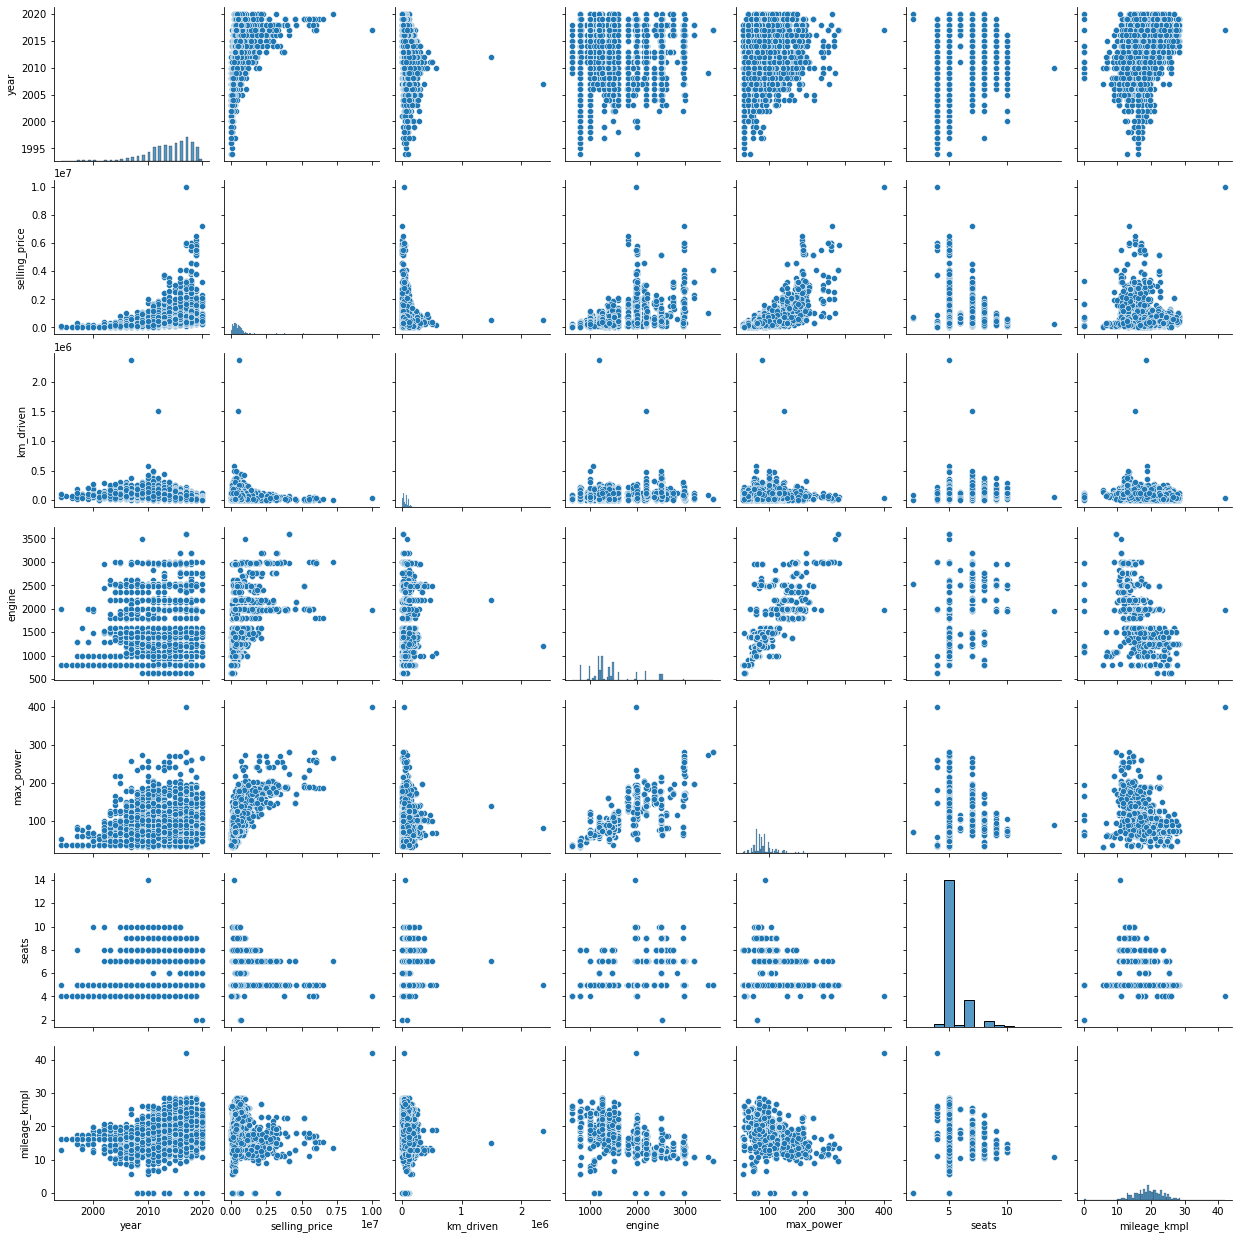

In [82]:
sns.pairplot(df)

In [83]:
# the data clearly has some outliers lets eliminate them
# lets examine the categorical variables

In [84]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Append specific columns like 'year' and 'seats' to the list of categorical columns
categorical_columns.extend(['year', 'seats'])

# Loop through each selected column and get the value counts
for column in categorical_columns:
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print("\n")

Value counts for fuel:
fuel
Diesel    4299
Petrol    3520
CNG         52
LPG         35
Name: count, dtype: int64


Value counts for seller_type:
seller_type
Individual          6563
Dealer              1107
Trustmark Dealer     236
Name: count, dtype: int64


Value counts for transmission:
transmission
Manual       6865
Automatic    1041
Name: count, dtype: int64


Value counts for owner:
owner
First Owner             5215
Second Owner            2016
Third Owner              510
Fourth & Above Owner     160
Test Drive Car             5
Name: count, dtype: int64


Value counts for brand:
brand
Maruti                2367
Hyundai               1360
Mahindra               747
Tata                   719
Honda                  466
Toyota                 452
Ford                   388
Chevrolet              230
Renault                228
Volkswagen             185
BMW                    118
Skoda                  104
Nissan                  81
Jaguar                  71
Volvo               

In [85]:
# eliminate outliers
def calculate_outlier_bounds(df):
    # Dictionary to store bounds for each column
    bounds = {}

    # Loop through each numeric column
    excluded_columns = ['year','seat']
    
    for col in (col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in excluded_columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds for the current column
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Store the bounds for this column
        bounds[col] = (lower_bound, upper_bound)

    return bounds

def apply_outlier_bounds(df, bounds):
    # Start with a copy of the original DataFrame
    df_filtered = df.copy()

    # Apply the bounds for each column
    for col, (lower_bound, upper_bound) in bounds.items():
        df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    
    return df_filtered

# Calculate the outlier bounds for each numeric column
outlier_bounds = calculate_outlier_bounds(df)

# Apply the calculated bounds to filter out outliers
df_no_outliers = apply_outlier_bounds(df, outlier_bounds)



In [86]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5631 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           5631 non-null   int64  
 1   selling_price  5631 non-null   int64  
 2   km_driven      5631 non-null   int64  
 3   fuel           5631 non-null   object 
 4   seller_type    5631 non-null   object 
 5   transmission   5631 non-null   object 
 6   owner          5631 non-null   object 
 7   engine         5631 non-null   float64
 8   max_power      5631 non-null   float64
 9   seats          5631 non-null   float64
 10  brand          5631 non-null   object 
 11  model          5631 non-null   object 
 12  mileage_kmpl   5631 non-null   float64
dtypes: float64(4), int64(3), object(6)
memory usage: 615.9+ KB


In [87]:
df_no_outliers.describe()

,year,selling_price,km_driven,engine,max_power,seats,mileage_kmpl
count,5631.000000,5.631000e+03,5631.000000,5631.000000,5631.000000,5631.0,5631.000000
mean,2014.021311,4.332082e+05,62778.463683,1241.794708,80.477440,5.0,20.689341
std,3.728853,2.376796e+05,37974.870072,230.066691,19.084413,0.0,3.304737
min,1994.000000,3.000000e+04,1.000000,793.000000,34.200000,5.0,8.546763
25%,2012.000000,2.460000e+05,31486.500000,1179.000000,67.100000,5.0,18.600000
50%,2015.000000,4.000000e+05,60000.000000,1199.000000,79.400000,5.0,20.500000
75%,2017.000000,6.000000e+05,90000.000000,1399.000000,88.730000,5.0,23.000000
max,2020.000000,1.300000e+06,186000.000000,1998.000000,150.000000,5.0,28.400000


In [88]:
categorical_columns = df_no_outliers.select_dtypes(include=['object']).columns.tolist()

# Append specific columns like 'year' and 'seats' to the list of categorical columns
categorical_columns.extend(['year', 'seats'])

# Loop through each selected column and get the value counts
for column in categorical_columns:
    print(f"Value counts for {column}:")
    print(df_no_outliers[column].value_counts())
    print("\n")

Value counts for fuel:
fuel
Petrol    3095
Diesel    2469
CNG         46
LPG         21
Name: count, dtype: int64


Value counts for seller_type:
seller_type
Individual          4799
Dealer               659
Trustmark Dealer     173
Name: count, dtype: int64


Value counts for transmission:
transmission
Manual       5182
Automatic     449
Name: count, dtype: int64


Value counts for owner:
owner
First Owner             3733
Second Owner            1414
Third Owner              375
Fourth & Above Owner     109
Name: count, dtype: int64


Value counts for brand:
brand
Maruti              2052
Hyundai             1316
Tata                 500
Honda                414
Ford                 362
Renault              203
Volkswagen           173
Chevrolet            163
Toyota               126
Skoda                 93
Nissan                79
Datsun                51
Mahindra              40
Fiat                  40
Mahindra Renault       5
Ambassador             4
Daewoo                 3
Mi

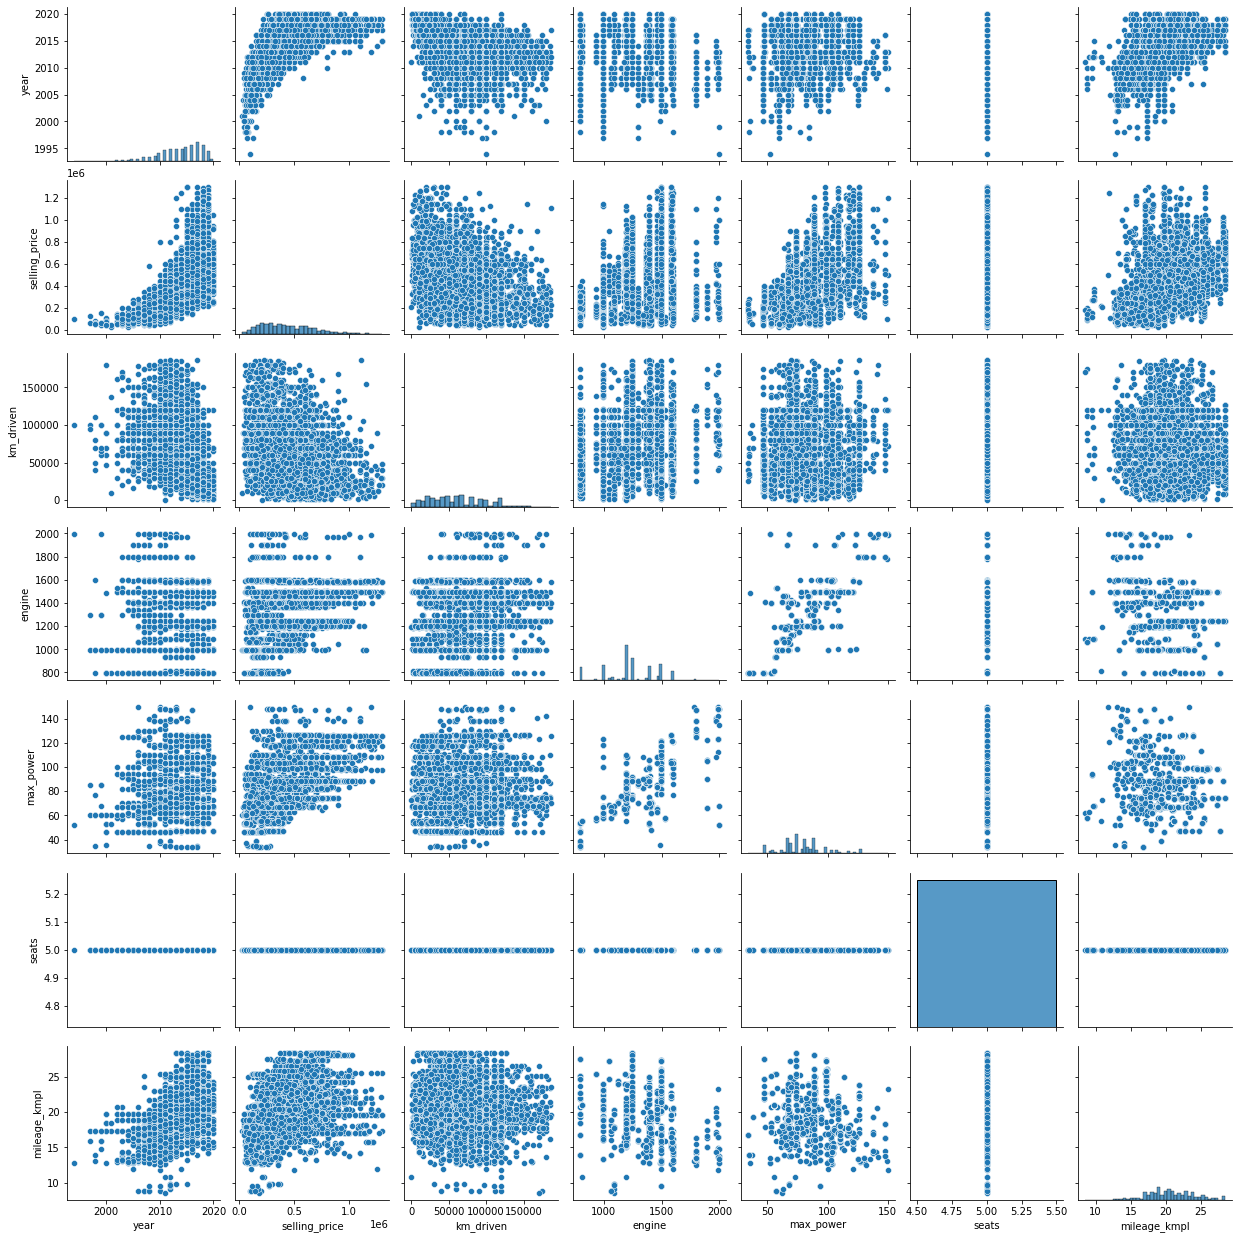

In [89]:
sns.pairplot(df_no_outliers)

In [90]:
df_no_outliers.drop(columns='seats', inplace=True)

In [91]:
# the pairplot reveals stronger relationships after outliers are removed
# the parplot also shows that a non linear model might perform better

In [92]:
# lets analyze for feature selection


In [95]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5631 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           5631 non-null   int64  
 1   selling_price  5631 non-null   int64  
 2   km_driven      5631 non-null   int64  
 3   fuel           5631 non-null   object 
 4   seller_type    5631 non-null   object 
 5   transmission   5631 non-null   object 
 6   owner          5631 non-null   object 
 7   engine         5631 non-null   float64
 8   max_power      5631 non-null   float64
 9   brand          5631 non-null   object 
 10  model          5631 non-null   object 
 11  mileage_kmpl   5631 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 571.9+ KB


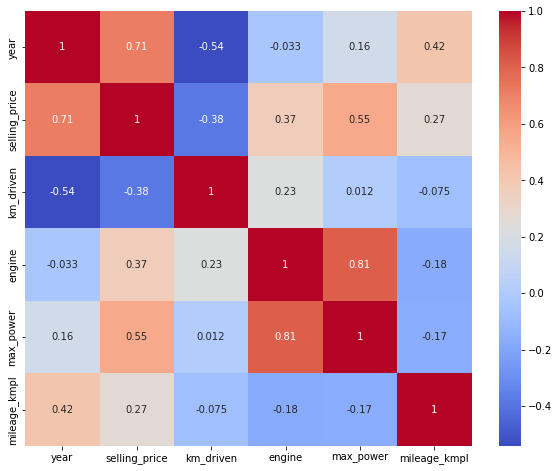

In [96]:
corr = df_no_outliers.select_dtypes(["float64","int64"]).corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [97]:
# the generaly lower coefficients might be as a result of pearsons correlation not being able to capture the dependency of non linear relationships

# max power and engine also seem highly correlated. if overfitting occurs we might consider taking one of them out

# since we arent using linear regression we can proceed as is

In [98]:
from sklearn.feature_selection import f_classif

# Convert categorical variables into numerical using one-hot encoding or label encoding
df_encoded = pd.get_dummies(df_no_outliers, drop_first=True)

# Apply ANOVA F-statistic
F_values, p_values = f_classif(df_encoded.drop('selling_price', axis=1), df_encoded['selling_price'])

feature_scores = pd.DataFrame({'Feature': df_encoded.drop('selling_price', axis=1).columns, 'F_value': F_values, 'p_value': p_values})
print(feature_scores.sort_values(by='F_value', ascending=False))


                          Feature    F_value        p_value
115                  model_Seltos        inf   0.000000e+00
41                    model_Astra        inf   0.000000e+00
28                     brand_Opel        inf   0.000000e+00
21                      brand_Kia        inf   0.000000e+00
0                            year  23.985562   0.000000e+00
49                   model_Captur  12.339926   0.000000e+00
132                  model_XUV300  11.150719   0.000000e+00
106                   model_Rapid   8.402120   0.000000e+00
15                   brand_Daewoo   7.560505   0.000000e+00
95                    model_Matiz   7.560505   0.000000e+00
56                    model_Creta   7.299217  4.972879e-318
9    seller_type_Trustmark Dealer   6.963013  4.585466e-300
3                       max_power   6.960873  5.974756e-300
134                   model_Yaris   6.871088  4.050166e-295
126                   model_Venue   6.404156  8.911793e-270
38                    model_Amaze   5.78

C:\Users\adenu\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [99]:
# since our p values are less than 0.05 there is significant variance in selling price accross the categorical variables
# it should be noted that some of the categgories for the categorical variable werent significant

In [100]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5631 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           5631 non-null   int64  
 1   selling_price  5631 non-null   int64  
 2   km_driven      5631 non-null   int64  
 3   fuel           5631 non-null   object 
 4   seller_type    5631 non-null   object 
 5   transmission   5631 non-null   object 
 6   owner          5631 non-null   object 
 7   engine         5631 non-null   float64
 8   max_power      5631 non-null   float64
 9   brand          5631 non-null   object 
 10  model          5631 non-null   object 
 11  mileage_kmpl   5631 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 571.9+ KB


In [101]:
#model selection

#since the data appears non linear lets explore two non linear models SVR and Random forest Regressor

In [102]:
X_clean = df_no_outliers.drop(columns = ['selling_price'])
y_clean = df_no_outliers['selling_price']

In [103]:
X_clean_train, X_clean_test, y_clean_train, y_clean_test = train_test_split(X_clean, y_clean, test_size = 0.1, random_state=3)

In [104]:
kf = KFold(n_splits=5, shuffle=True, random_state=3)

### using SVR

In [105]:
svr = SVR() 

In [106]:
# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), X_clean_train.select_dtypes("float64","int64").columns),  # Scaling numeric features
        ('categorical', OneHotEncoder(use_cat_names = True), X_clean_train.select_dtypes("object").columns)  # One-hot encoding categorical features
    ])

# Create a pipeline with the preprocessor and a model (e.g., Linear Regression)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', svr )  # Example model, you can replace it with any ML model
])

In [107]:
# Use cross_validate to get both train and test scores, and use parallel processing (n_jobs=-1)
cv_results = cross_validate(model, X_clean_train, y_clean_train, cv=kf, 
                            return_train_score=True,n_jobs =-1)

# Get average training and cross-validation scores
average_train_score = np.mean(cv_results['train_score'])
average_cv_score = np.mean(cv_results['test_score'])
        
average_train_score, average_cv_score

(-0.023138708820030284, -0.025214817386834953)

## Using random forest regressor

In [108]:
rf = RandomForestRegressor()

In [116]:
# Create a pipeline with the preprocessor and a model (e.g., Linear Regression)
model = Pipeline(steps=[
    ('Encoder', OneHotEncoder(use_cat_names = True)),
    ('model', rf)  # Example model, you can replace it with any ML model
])

In [110]:
cv_results = cross_validate(model, X_clean_train, y_clean_train, cv=kf, 
                            return_train_score=True, n_jobs=-1)

# Get average training and cross-validation scores
average_train_score = np.mean(cv_results['train_score'])
average_cv_score = np.mean(cv_results['test_score'])

average_train_score, average_cv_score

(0.9864440601851703, 0.9176021556919067)

In [111]:
# examine feature importance
model.fit(X_clean_train, y_clean_train)

# Extract the trained RandomForestRegressor model from the pipeline
rf_model = model.named_steps['model']

# Get the feature names from the one-hot encoder
encoder = model.named_steps['Encoder']
encoded_feature_names = encoder.get_feature_names_out(X_clean_train.select_dtypes("object").columns)

# Get the feature importances from the RandomForest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,year,5.405140e-01
16,max_power,2.926003e-01
1,km_driven,3.469925e-02
15,engine,2.691214e-02
141,mileage_kmpl,2.522064e-02
19,brand_Tata,8.038825e-03
76,model_Creta,7.004715e-03
52,model_City,3.556281e-03
12,owner_First Owner,3.099018e-03
57,model_Swift,2.346812e-03


In [113]:
X_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5631 entries, 0 to 8127
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          5631 non-null   int64  
 1   km_driven     5631 non-null   int64  
 2   fuel          5631 non-null   object 
 3   seller_type   5631 non-null   object 
 4   transmission  5631 non-null   object 
 5   owner         5631 non-null   object 
 6   engine        5631 non-null   float64
 7   max_power     5631 non-null   float64
 8   brand         5631 non-null   object 
 9   model         5631 non-null   object 
 10  mileage_kmpl  5631 non-null   float64
dtypes: float64(3), int64(2), object(6)
memory usage: 527.9+ KB


In [117]:

# focus on important features to prevent overfitting
X_train_important_columns = X_clean_train.drop(columns = ['fuel','seller_type','transmission','owner'])


In [118]:
# Create a pipeline with the preprocessor and a model (e.g., Linear Regression)
model = Pipeline(steps=[
    ('Encoder', OneHotEncoder(use_cat_names = True)),
    ('model', rf)  # Example model, you can replace it with any ML model
])

In [119]:
cv_results = cross_validate(model, X_train_important_columns, y_clean_train, cv=kf, 
                            return_train_score=True, n_jobs=-1)

# Get average training and cross-validation scores
average_train_score = np.mean(cv_results['train_score'])
average_cv_score = np.mean(cv_results['test_score'])

average_train_score, average_cv_score

(0.9839046953915787, 0.914117973384112)

In [120]:
# since no significant reduction in overfitting we use full features
# this decision is also influenced by clients requirement

In [121]:
# course hyperparameter tuning
param_distributions = {
    'model__n_estimators': [50, 75, 100, 150,200],
    'model__max_depth': [None, 10, 20, 30, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_impurity_decrease': [0.0, 0.01, 0.05],
    'model__max_samples': [None, 0.5, 0.75, 0.9],
    'model__max_features': [None, 0.5, 'sqrt', 'log2']
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,  # Your pipeline object
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',  # Example scoring metric
    cv=5,  # Cross-validation folds
    verbose=2,
    n_jobs=-1,  # Use all available processors
    random_state=42,
    return_train_score=True
)

# Fit the random search model
random_search.fit(X_clean_train, y_clean_train)

# Get the best parameters
print("Best Parameters (Coarse Search):", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters (Coarse Search): {'model__n_estimators': 75, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__min_impurity_decrease': 0.01, 'model__max_samples': 0.9, 'model__max_features': 0.5, 'model__max_depth': 20}


In [122]:
np.max(random_search.cv_results_['mean_train_score']), random_search.best_score_

(0.9870449951642627, 0.9205917028165675)

In [123]:
# fine Hyperparameter Tuning
param_grid_fine = {
    'model__n_estimators': [180, 200, 220],
    'model__max_depth': [48, 50, 52],
    'model__min_samples_split': [2, 3],
    'model__min_samples_leaf': [1, 2],
    'model__min_impurity_decrease': [0.04, 0.05, 0.06],
    'model__max_samples': [0.9,None],
    'model__max_features': [0.4,0.5,0.6]
}


grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid_fine,
        scoring='r2',
        cv=5,
        verbose=2,
        n_jobs=-1,  # Use all available processors
    return_train_score=True
    
     )
grid_search.fit(X_clean_train, y_clean_train)
print("Best Parameters (Fine Search):", grid_search.best_params_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters (Fine Search): {'model__max_depth': 52, 'model__max_features': 0.4, 'model__max_samples': None, 'model__min_impurity_decrease': 0.06, 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 200}


In [124]:
np.max(grid_search.cv_results_['mean_train_score']), grid_search.best_score_

(0.9871610418164822, 0.9219291484692839)

In [125]:
car_price_predictor = grid_search.best_estimator_

In [126]:
car_price_predictor.fit(X_clean_train, y_clean_train)

Pipeline(steps=[('Encoder',
                 OneHotEncoder(cols=['fuel', 'seller_type', 'transmission',
                                     'owner', 'brand', 'model'],
                               use_cat_names=True)),
                ('model',
                 RandomForestRegressor(max_depth=52, max_features=0.4,
                                       min_impurity_decrease=0.06,
                                       min_samples_split=3,
                                       n_estimators=200))])

In [127]:
y_pred = car_price_predictor.predict(X_clean_test)

In [128]:
mae = mean_absolute_error(y_clean_test, y_pred)

In [129]:
print(f"Mean Absolute Error (MAE) on the test set: {mae}")

Mean Absolute Error (MAE) on the test set: 44684.258297536624


In [130]:
y_clean_test.mean()

417019.4609929078

In [131]:
error_margin =(mae/y_clean_test.mean())*100

In [132]:
error_margin

10.715149406012149

In [133]:
car_price_predictor


Pipeline(steps=[('Encoder',
                 OneHotEncoder(cols=['fuel', 'seller_type', 'transmission',
                                     'owner', 'brand', 'model'],
                               use_cat_names=True)),
                ('model',
                 RandomForestRegressor(max_depth=52, max_features=0.4,
                                       min_impurity_decrease=0.06,
                                       min_samples_split=3,
                                       n_estimators=200))])

In [134]:
with open("C:/Users/adenu/Downloads/Python_notebooks-2/Python_notebooks/ML Projects/Car price prediction project 2.0/Car price prediction model/car_price_predictor.pkl", 'wb') as file:
    pickle.dump(car_price_predictor, file)

In [135]:
# create model and brand features for model on streamlit

brand_model_dict=df_no_outliers.groupby('brand')['model'].apply(lambda x: list(set(x))).to_dict()

In [136]:
brand_model_dict

{'Ambassador': ['Grand', 'Classic'],
 'Chevrolet': ['Optra', 'Aveo', 'Sail', 'Spark', 'Cruze', 'Beat'],
 'Daewoo': ['Matiz'],
 'Datsun': ['GO', 'RediGO'],
 'Fiat': ['Avventura', 'Punto', 'Linea', 'Grande Punto'],
 'Ford': ['Fiesta',
  'EcoSport',
  'Freestyle',
  'Figo',
  'Ikon',
  'Fusion',
  'Classic',
  'Aspire'],
 'Honda': ['Jazz', 'City', 'Civic', 'Amaze', 'Brio', 'WR-V'],
 'Hyundai': ['Venue',
  'Accent',
  'Xcent',
  'Elantra',
  'i10',
  'Verna',
  'Creta',
  'Grand i10',
  'Getz',
  'Elite',
  'i20',
  'Santro',
  'EON',
  'Sonata'],
 'Kia': ['Seltos'],
 'Mahindra': ['XUV300', 'KUV 100', 'Logan', 'Verito'],
 'Mahindra Renault': ['Logan'],
 'Maruti': ['Eeco',
  'Dzire',
  'Swift',
  'SX4',
  'Vitara Brezza',
  'Celerio',
  'Ciaz',
  'Omni',
  'Esteem',
  'Baleno',
  '800',
  'A-Star',
  'S-Presso',
  'Wagon R',
  'Alto',
  'Ignis',
  'Zen',
  'Ritz',
  'S-Cross'],
 'Mercedes-Benz': ['B Class'],
 'Mitsubishi': ['Lancer'],
 'Nissan': ['Sunny', 'Micra', 'Terrano', 'Kicks'],
 'Ope